# Classificator

## Problem specification

Consider a training set $\mathcal{D} = \{ (x_i, y_i) \mid i = 1...m \}$ where $x_i$ and $y_i$ are respectively the features and the label of $i$-th item. 

After having trained your classificator on set $\mathcal{D}$, given a feature array $x'$ guess its label $y'$. 

## A very famous example

**[Iris Classification](https://en.wikipedia.org/wiki/Iris_flower_data_set)**

From Fisher's 1936 paper *The use of multiple measurements in taxonomic problems*, one of the first example of classification.

There are three species of Iris: *setosa* ($y=0$), *versicolor* ($y=1$), *virginica* ($y=2$). Ronald chooses as feature: sepal width, sepal length, petal width, petal length.

Fisher's dataset has this form:
$$ D = \big\{ (x_i, y_i) \mid i = 1...150, x_i = (sw, sl, pw, pl) \in \mathbb{R}^4, y_i \in \{0, 1, 2\} \big\} $$

A classificator solving this problem is a function $C_{\mathcal{D}}$ such that $C_{\mathcal{D}}(x') = y' \in \{0, 1, 2\}$ given $x' \in \mathbb{R}^4$.

### At the end of the course...

... you will be asked to modify the classifiers presented during this lesson to solve *Iris classification* problem.

## Some concepts

### Binary classificator

Only has two possibile $y$ labels, tipically $+1$ and $-1$. 

### Distance function

Suppose we have function $d$ defined on our feature array $x \in \mathbb{R}^m$. If $d : \mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$ has these three properties:
1. $d(x, x) = 0$ for all feature array $x$;
2. $d(x, y) = d(y, x)$ for all feature arrays $x, y$;
3. $d(x, z) \le d(x, y) + d(y, z)$ for all feature arrays $x, y, z$
then $d$ is a *metric* or *distance function*. 

One trivial metrics: $d(a, b) = \sum_{i = 1}^{m} (a_i - b_i)^2$ is called *mean square error*. 

### Distance based classificator

We can find for our binary classificator the representatives $x_1, x_2$ for the classes $y_1 = +1, y_2 = -1$. Then our classificator can be:

`classify(x) = if d(x1, x) < d(x2, x) then y1 else y2`

or equivalently

`classify(x) = sign(y1*d(x1,x) + y2*d(x2, x)) = sign((1)*d(x1, x) + (-1)*d(x2, x))`.

How can we find the two (best) representatives $x_1, x_2$...?

## Hands on

### The key component of our distance based classifier

is called *SWAP test*. It lets you calculate the inner product $\langle x | y \rangle$ of two quantum states $x, y$.
* inner product = how much does two state overlaps?
* range of inner product: $0 \le \langle x | y \rangle \le 1$
* if $\langle x | y \rangle$ is high ($\approx 1$) then we can say they're close to each other (distance is low)
* if $\langle x | y \rangle$ is low ($\approx 0$) then we can say they're far to each other (distance is high)

Given two states $|a\rangle, |b\rangle$ (with the same number of qubits, one or more), and a single *ancilla* state initialized to $|0\rangle$ we can implement the following circuit:

![Swap test pic](swaptest.png)

Measuring ancilla register give us $|0\rangle$ with a certain probability, which must be interpreted this way:

$$
\mathrm{Pr}[\text{ancilla readout }0] = \frac{1 + |\langle p | q \rangle|^2}{2}
\qquad
\mathrm{Pr}[\text{ancilla readout }1] = \frac{1 - |\langle p | q \rangle|^2}{2}$$

### How to calculate inner product of two states analitically

Be $|p\rangle = |00\rangle$ and $|q\rangle = |0+\rangle$.

Then $\langle 00 | 0+ \rangle = \begin{bmatrix} 1^* & 0^* & 0^* & 0^* \end{bmatrix} \begin{bmatrix} 1/\sqrt{2} \\ 1/\sqrt{2} \\ 0 \\ 0 \end{bmatrix} = 1/\sqrt{2} \approx 0.707$.

Finally $|\langle 00 | 0+ \rangle|^2 = (1/\sqrt{2})^2 = 1/2$.

### Qiskit implementation of SWAP test

We can easily define a function that append the SWAP test to any circuit. We must pass 
* the circuit we are working on ;
* the two registers `first_reg`, `second_reg` which must have the same size;
* the ancilla register
* the ancilla "readout" classical register

In [1]:
%matplotlib inline
from qiskit import *
import math
import numpy

def swap_test(circuit, first_reg, second_reg, ancilla, ancilla_readout):
    """
    Apply swap test to any qubit of the given register
    """
    circuit.barrier()
    circuit.h(ancilla[0])
    for i in range(0, len(first_reg)):
        circuit.cswap(ancilla[0], first_reg[i], second_reg[i])
    circuit.h(ancilla[0])
    circuit.measure(ancilla[0], ancilla_readout[0])
    return circuit

### Convince yourself that this circuit works

Some tests:

In [2]:
# How many qubits for |p>, |q> register?
n = 2

p  = QuantumRegister(n, 'p')
q  = QuantumRegister(n, 'q')
a  = QuantumRegister(1, 'anc')
ar = ClassicalRegister(1, 'ancr')
circuit = QuantumCircuit(p, q, a, ar)

# Initialize registers here!
circuit.h(q[0])
circuit.h(q[1])


swap_test(circuit, p, q, a, ar)
counts = execute(circuit, backend=Aer.get_backend("qasm_simulator"), shots=100000).result().get_counts()
count_0 = counts.get('0', 0)
count_1 = counts.get('1', 0)
probability_0 = count_0 / ( count_0 + count_1 )
inner_product_squared = 2 * probability_0 - 1

print("Inner product squared is {: .3f}".format(inner_product_squared))
print(circuit.draw())

Inner product squared is  0.252
              ░                    
   p_0: ──────░───────X────────────
              ░       │            
   p_1: ──────░───────┼──X─────────
        ┌───┐ ░       │  │         
   q_0: ┤ H ├─░───────X──┼─────────
        ├───┤ ░       │  │         
   q_1: ┤ H ├─░───────┼──X─────────
        └───┘ ░ ┌───┐ │  │ ┌───┐┌─┐
 anc_0: ──────░─┤ H ├─■──■─┤ H ├┤M├
              ░ └───┘      └───┘└╥┘
ancr: 1/═════════════════════════╩═
                                 0 


Some results:

|  $|p\rangle$ |  $|q\rangle$ | $\langle p|q\rangle$ | $|\langle p|q\rangle|^2$ expected | $|\langle p|q\rangle|^2$ actual |
|---------------|---------------|-----------------------:|--------------------------------------:|------------------------------------:|
| ====== | ====== | ====== | =============== | =============== |
| $|0\rangle$  | $|0\rangle$  |                  1.000 |                                 1.000 |                               1.000 |
| $|1\rangle$  | $|1\rangle$  |                  1.000 |                                 1.000 |                               1.000 |
| $|+\rangle$  | $|+\rangle$  |                  1.000 |                                 1.000 |                               1.000 |
| $|0\rangle$  | $|1\rangle$  |                  0.000 |                                 0.000 |                              -0.006 |
| $|0\rangle$  | $|+\rangle$  |                  0.707 |                                 0.500 |                               0.498 |
| $|00\rangle$ | $|00\rangle$ |                  1.000 |                                 1.000 |                               1.000 |
| $|00\rangle$ | $|0+\rangle$ |                  0.707 |                                 0.500 |                               0.502 |
| $|00\rangle$ | $|++\rangle$ |                  0.500 |                                 0.250 |                               0.247 |

*Note*: if $|p\rangle, |q\rangle$ orthogonal then we have 50/50% probability to read zero and one. However, due to hardware error we can have something like 48/52% of probability to read 0 and 1 respectively, so our inner product squared is sightly less than zero.

You can consider an error of $\pm 0.01$.

## Schuld-Fingerhuth-Petruccione Classificator

### Resources

Paper: [Implementing a distance-based classifier with a quantum interference circuit](https://arxiv.org/pdf/1703.10793.pdf)

Schuld's post on Medium.com: [link](https://medium.com/qiskit/building-the-worlds-smallest-quantum-classifier-7da7cd845b84)

Fingerhuth's Github w/ source code: [link](https://github.com/markf94/ibmq_code_epl_119_60002)

### The paper, briefly

Quantum circuit implementing the distance-based classifier using the two training vectors $x_0$ and $x_1$
and the input vector $\tilde{x}$ from Iris flower dataset. 

### Training set and testing set

For each vector $x$ in Iris dataset we use only two features instead of four, each vector now fits in a single-qubit register. Finally it's scaled and normalized.

At this point, $x$ represent a point on the unit circle. We can efficiently encode it using a single rotation $\textrm{Ry}(\theta)$. In particular, given $x = (a, b) \in \mathbb{R}^2 \iff \cos(\theta) = a \land \sin(\theta) = b \iff \tan(\theta) = b/a$. 

*Note*: function `atan2(b,a)` handles also special cases like $a = 0$.

The training dataset is:
* $x_0 = (0, 1), y_0 = -1$ (Iris sample 33 from Roberts), and 
* $x_1 = (0.7886, 0.6148), y_1 = 1$ (Iris sample 85). 

Testing set is:
* $x' = (-0.549, 0.836)$
* $x'' = (0.053, 0.999)$.

For these vectors, the associated angles are: 

| vector   |         a |        b |              theta = 2 * atan2(b,a) |
|----------|----------:|---------:|------------------------------------:|
| $x_0 $   | $ 0.0000$ | $1.0000$ | $                              \pi$ |
| $x_1 $   | $ 0.7886$ | $0.6148$ | $                       1.32436684$ |
| $x'  $   | $-0.5489$ | $0.8358$ | $-1.97940061$ <br/>($+2\pi = 4.3036448$) |
| $x'' $   | $ 0.0531$ | $0.9986$ | $                       3.03534383$ |

You must pass $\textrm{Ry}$ angles multiplied by two (see matrix definition of $\mathrm{Ry}$ operator).

In [3]:
names = ["x0",   "x1",    "x'",  "x''"]
a     = [   0, 0.7886, -0.5489, 0.0531]
b     = [   1, 0.6148,  0.8358, 0.9986]
thetas = 2 * numpy.arctan2(b, a)
thetas

array([3.14159265, 1.32436684, 4.3037847 , 3.03534383])

You can check that the angle $\theta$ associated to $x$ perform this transofrmation:

$$ |0\rangle \mapsto \mathrm{Ry}(\theta)|0\rangle = |x\rangle$$

In [4]:
def is_angle_correct(vector, angle):
    circuit = QuantumCircuit(1, 1)
    circuit.ry(angle, 0)
    statevector = execute(circuit, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
    return numpy.allclose(vector, statevector, atol=0.001)

# training set x0 angle. Note that Ry(pi) = X operator
print("Training set x0  correctness: ", is_angle_correct([0, 1], math.pi))
    
# training set x1 angle
print("Training set x1  correctness: ", is_angle_correct([0.78861006, 0.614893628], 1.3245))

# training set x' angle. Note that Ry(pi) = X operator
print("Testing  set x'  correctness: ", is_angle_correct([-0.5488819155, 0.8358999], 4.30417579487669))

# training set x'' angle
print("Testing  set x'' correctness: ", is_angle_correct([0.05308495, 0.99859], 3.0357101997648965))

Training set x0  correctness:  True
Training set x1  correctness:  True
Testing  set x'  correctness:  True
Testing  set x'' correctness:  True


### The formula

The dataset is:

$$ \mathcal{D} = \{ (x_0, y_0); (x_1, y_1) \} \qquad y_0 = -1 \qquad y_1 = 1$$

Then the predected label is:
$$ \tilde{y} 
= \textrm{sign} \Big( \sum_{m \in \{0, 1\}} y_m \cdot \Big[ 1 - \frac{1}{4 \cdot |\mathcal{D}|} \langle \tilde{x} | x_m \rangle^2 \Big] \Big)$$

### The circuit

In [5]:
from qiskit.circuit.library.standard_gates import *

x_1     = [ 0.0000, 1.0000]
x_0     = [ 0.7886, 0.6148]
x_tilde = [ 0.0531, 0.9986]

theta_0 = 2 * numpy.arctan2(x_0[1], x_0[0])
theta_1 = 2 * numpy.arctan2(x_1[1], x_1[0])
theta_tilde = 2 * numpy.arctan2(x_tilde[1], x_tilde[0])

ancilla_reg = QuantumRegister(1, 'ancilla')
index_reg   = QuantumRegister(1, 'index')
data_reg    = QuantumRegister(1, 'data')
class_reg   = QuantumRegister(1, 'class')
readout_reg = ClassicalRegister(4, 'readout')

circuit = QuantumCircuit(ancilla_reg, index_reg, data_reg, class_reg, readout_reg)

In [6]:
# STEP A: The ancilla and index qubits are put into uniform superposition.
circuit.h(ancilla_reg[0])
circuit.h(index_reg[0])

# STEP B: The test vector $x_tilde$ is entangled with the ground state of the ancilla.
circuit.barrier()
circuit.cry(theta_tilde, ancilla_reg[0], data_reg[0]) # (!) x' initialization; x' is entangle with ANCILLA=0
circuit.draw()

┌───┐ ░               
ancilla_0: ┤ H ├─░───────■───────
           ├───┤ ░       │       
  index_0: ┤ H ├─░───────┼───────
           └───┘ ░ ┌─────┴──────┐
   data_0: ──────░─┤ RY(3.0353) ├
                 ░ └────────────┘
  class_0: ──────░───────────────
                 ░               
readout: 4/══════════════════════

In [7]:
# STEP C: The training vector $x_0$ is entangled with the excited state 
# of the ancilla and the ground state of the index qubit.
circuit.barrier()
circuit.x(ancilla_reg[0]) 
CCRY_X0 = RYGate(theta_0).control(2) # create 2*controlled version of this gate
circuit.append(CCRY_X0, [ancilla_reg[0], index_reg[0], data_reg[0]]) # (!) x0 initialization; x0 must be entangle with ANCILLA=1, INPUT=0

# STEP D: Entangle training vector $x_1$ with the excited state of the ancilla and the index qubit.
circuit.barrier()
circuit.x(index_reg[0])
CCRY_X1 = RYGate(theta_1).control(2) # create 2*controlled version of this gate
circuit.append(CCRY_X1, [ancilla_reg[0], index_reg[0], data_reg[0]]) # (!) x1 initialization; x1 must be entangle with ANCILLA=1, INPUT=1
circuit.draw()

┌───┐ ░                ░ ┌───┐               ░                
ancilla_0: ┤ H ├─░───────■────────░─┤ X ├──────■────────░──────────■─────
           ├───┤ ░       │        ░ └───┘      │        ░ ┌───┐    │     
  index_0: ┤ H ├─░───────┼────────░────────────■────────░─┤ X ├────■─────
           └───┘ ░ ┌─────┴──────┐ ░      ┌─────┴──────┐ ░ └───┘┌───┴────┐
   data_0: ──────░─┤ RY(3.0353) ├─░──────┤ RY(1.3244) ├─░──────┤ RY(pi) ├
                 ░ └────────────┘ ░      └────────────┘ ░      └────────┘
  class_0: ──────░────────────────░─────────────────────░────────────────
                 ░                ░                     ░                
readout: 4/══════════════════════════════════════════════════════════════

In [8]:
# STEP E: The data and class qubits are swapped and the class qubit is flipped conditioned
# on the index qubit being $|1\rangle$ which completes the initial state preparation.
circuit.barrier()
circuit.cswap(index_reg[0], data_reg[0], class_reg[0])

# STEP F: The Hadamard gate interferes the copies of $\tilde{x}$ with the training vectors 
# and the ancilla is measured followed by a measurement of the class qubit (due to prior 
# swapping now at the position of the |i> qubit) when the ancilla was found to 
# be in the |0> state.
circuit.barrier()
circuit.h(ancilla_reg[0])
circuit.measure([ancilla_reg[0], index_reg[0], data_reg[0], class_reg[0]], readout_reg)
circuit.draw()

┌───┐ ░                ░ ┌───┐               ░                 ░    »
ancilla_0: ┤ H ├─░───────■────────░─┤ X ├──────■────────░──────────■──────░────»
           ├───┤ ░       │        ░ └───┘      │        ░ ┌───┐    │      ░    »
  index_0: ┤ H ├─░───────┼────────░────────────■────────░─┤ X ├────■──────░──■─»
           └───┘ ░ ┌─────┴──────┐ ░      ┌─────┴──────┐ ░ └───┘┌───┴────┐ ░  │ »
   data_0: ──────░─┤ RY(3.0353) ├─░──────┤ RY(1.3244) ├─░──────┤ RY(pi) ├─░──X─»
                 ░ └────────────┘ ░      └────────────┘ ░      └────────┘ ░  │ »
  class_0: ──────░────────────────░─────────────────────░─────────────────░──X─»
                 ░                ░                     ░                 ░    »
readout: 4/════════════════════════════════════════════════════════════════════»
                                                                               »
«            ░ ┌───┐      ┌─┐
«ancilla_0: ─░─┤ H ├──────┤M├
«            ░ └┬─┬┘      └╥┘
«  index_0: ─░──┤M├────────╫─
«            ░  └╥┘ ┌─┐    ║ 
«   data_0: ─░───╫──┤M├────╫─
«            ░   ║  └╥┘┌─┐ ║ 
«  class_0: ─░───╫───╫─┤M├─╫─
«            ░   ║   ║ └╥┘ ║ 
«readout: 4/═════╩═══╩══╩══╩═
«                1   2  3  0

### Results interpretation

In [9]:
def interpret_results(result_counts):
        
    # pass from dictionary notation {key: value} to list notation [ (key, value) ]
    count_list = list(result_counts.items())
    #print(f"Readout: {count_list}")
    
    # keep results only when ANCILLA=0, discard any ANCILLA=1
    ANCILLA_INDEX = 3 # bit0 least significative -> last in string
    count_list = [(state, occ) for state, occ in count_list if state[ANCILLA_INDEX] == '0']
    #print(f"Only ANCILLA=0: {count_list}")

    # get results for each class
    CLASS_INDEX = 2
    count_0 = [(state, occ) for state, occ in count_list if state[CLASS_INDEX] == '0']
    count_1 = [(state, occ) for state, occ in count_list if state[CLASS_INDEX] == '1']
    #print(f"Class 0: {count_0}")
    #print(f"Class 1: {count_1}")
    
    total  = sum([occ for _, occ in count_list])
    prob_0 = sum([occ for _, occ in count_0]) / total
    prob_1 = sum([occ for _, occ in count_1]) / total
    
    return (prob_0, prob_1)

def get_class(prob_0, prob_1):
    if numpy.abs(prob_0 - prob_1) < 0.01:
        return "50/50"
    elif prob_0 > prob_1:
        return "Y0"
    else:
        return "Y1"    
    
result_counts = execute(circuit, Aer.get_backend('qasm_simulator'), shots=16384).result().get_counts()
(prob_0, prob_1) = interpret_results(result_counts)
print(f"Probability class 0: {prob_0}; probability class 1: {prob_1}")
print(f"Class: {get_class(prob_0, prob_1)}")

Probability class 0: 0.4540229885057471; probability class 1: 0.5459770114942529
Class: Y1


### When running on a real quantum device...

In [10]:
circuit.draw()

┌───┐ ░                ░ ┌───┐               ░                 ░    »
ancilla_0: ┤ H ├─░───────■────────░─┤ X ├──────■────────░──────────■──────░────»
           ├───┤ ░       │        ░ └───┘      │        ░ ┌───┐    │      ░    »
  index_0: ┤ H ├─░───────┼────────░────────────■────────░─┤ X ├────■──────░──■─»
           └───┘ ░ ┌─────┴──────┐ ░      ┌─────┴──────┐ ░ └───┘┌───┴────┐ ░  │ »
   data_0: ──────░─┤ RY(3.0353) ├─░──────┤ RY(1.3244) ├─░──────┤ RY(pi) ├─░──X─»
                 ░ └────────────┘ ░      └────────────┘ ░      └────────┘ ░  │ »
  class_0: ──────░────────────────░─────────────────────░─────────────────░──X─»
                 ░                ░                     ░                 ░    »
readout: 4/════════════════════════════════════════════════════════════════════»
                                                                               »
«            ░ ┌───┐      ┌─┐
«ancilla_0: ─░─┤ H ├──────┤M├
«            ░ └┬─┬┘      └╥┘
«  index_0: ─░──┤M├────────╫─
«            ░  └╥┘ ┌─┐    ║ 
«   data_0: ─░───╫──┤M├────╫─
«            ░   ║  └╥┘┌─┐ ║ 
«  class_0: ─░───╫───╫─┤M├─╫─
«            ░   ║   ║ └╥┘ ║ 
«readout: 4/═════╩═══╩══╩══╩═
«                1   2  3  0

/home/incud/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


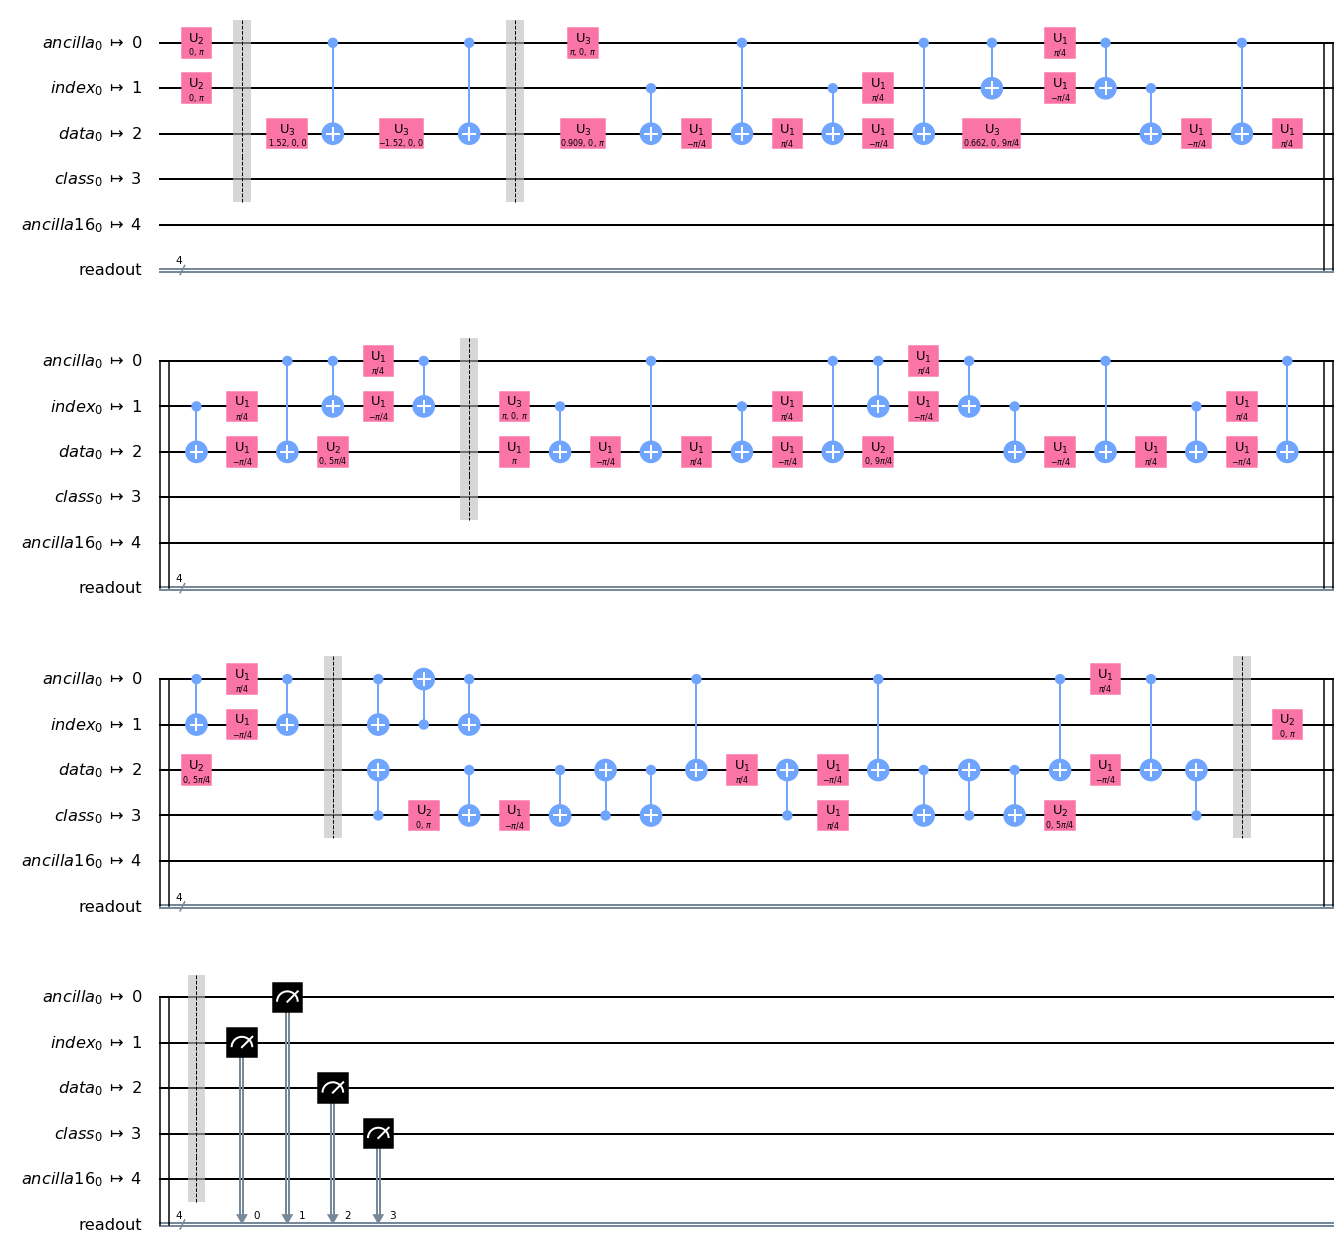

In [12]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_5_yorktown')
new_circuit = transpile(circuit, backend)
new_circuit.draw(output='mpl')

# Variational classifiers



In [13]:
import pennylane as qml
from pennylane import numpy as np # important!

## Creating the first circuit on Pennylane

First we create a quantum device.

*Pennylane* has in-build simulators and also lets you run the circuit on some real architectures (Qiskit, Google Cirq, ...).

In [14]:
dev = qml.device('default.qubit', wires=1) # default simulator, 1 qubit

Through decorator `@qml.qnode(dev)` we specify which platform will Pennylane use to run the circuit. It is equivalent to Qiskit's `execute(circuit, backend=dev)`.

In [15]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    # qubit 0 measurement on |0>, |1> basis
    return qml.expval(qml.PauliZ(0)) 

This circuit implements the following transformation:

$$ |0\rangle \mapsto |\psi\rangle = R_y(\theta_2) R_x(\theta_1) |0\rangle $$

The expected outcome is:

$$ \langle \psi | \sigma_z | \phi \rangle
= \langle 0 | R_x(\theta_1)^\dagger R_y(\theta_2)^\dagger \sigma_z R_y(\theta_2) R_x(\theta_1) | 0 \rangle
= \cos(\theta_1) \cos(\theta_2)
$$

In [16]:
params = [0, 0.5]
print(f"{circuit(params)} equals {np.cos(params[0]) * np.cos(params[1])}")

params = [0, 0]
print(f"{circuit(params)} equals {np.cos(params[0]) * np.cos(params[1])}")

0.8775825618903726 equals 0.8775825618903728
1.0 equals 1.0


## Optimize the cost function

We define a cost function using our circuit.

In [17]:
def cost(x):
    return circuit(x)

In [20]:
opt = qml.GradientDescentOptimizer(stepsize=0.05)

steps = 30

params = [0.5, 0.5] # random initial parameters

In [21]:
for i in range(steps):
    # update params
    params = opt.step(cost, params)
    # print updates
    print("Cost after step {:2d}: {: .5f}".format(i, cost(params)))
    
print("Optimized rotation angles: params[0]={:.4f} params[1]={:.4f}".format(params[0], params[1]))

Cost after step  0:  0.75222
Cost after step  1:  0.73335
Cost after step  2:  0.71357
Cost after step  3:  0.69292
Cost after step  4:  0.67145
Cost after step  5:  0.64920
Cost after step  6:  0.62627
Cost after step  7:  0.60272
Cost after step  8:  0.57867
Cost after step  9:  0.55420
Cost after step 10:  0.52944
Cost after step 11:  0.50450
Cost after step 12:  0.47950
Cost after step 13:  0.45458
Cost after step 14:  0.42985
Cost after step 15:  0.40544
Cost after step 16:  0.38146
Cost after step 17:  0.35801
Cost after step 18:  0.33520
Cost after step 19:  0.31311
Cost after step 20:  0.29181
Cost after step 21:  0.27137
Cost after step 22:  0.25183
Cost after step 23:  0.23323
Cost after step 24:  0.21559
Cost after step 25:  0.19892
Cost after step 26:  0.18323
Cost after step 27:  0.16850
Cost after step 28:  0.15473
Cost after step 29:  0.14188
Optimized rotation angles: params[0]=1.1846 params[1]=1.1846


# Exercises

Try to modify one of the classifier presented during the lesson in order to solve *Iris classification*.

* (+) test accuracy of classifier;
* (+) 2 features $\to$ 4 features;
* (++) implement IRIS in variational model ([*hint*](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html#iris-classification));
* (+++) binary classification $\to$ n-ary classification.

The dataset can be found in `scikit-learn` library.

In [22]:
!pip install scikit-learn

In [23]:
from sklearn import datasets
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [24]:
print(iris.data[0:10])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


In [25]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [26]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']
